In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:80% !important; }</style>"))
import sys
sys.path.append('/home/chenani/ownCloud/Workspaces/Eclipse/dataAnalysis/Sleep-current/src/')

In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
import pandas as pd
from scipy.misc import comb
import scipy as scp
import numpy as np
import matplotlib.pyplot as pl
import pickle as pkl
import sets
import random
import itertools
import os,sys,fnmatch
import timeit
import scipy.stats
import seaborn as sns
from IPython.core.display import display, HTML
from scipy.stats import chisquare
sns.set_style("ticks",{ 'legend.frameon': False})

/home/chenani/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:10: DeprecationWarning: the sets module is deprecated
/home/chenani/anaconda/lib/python2.7/site-packages/matplotlib/__init__.py:872: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


In [2]:
def locate(pattern, root=os.curdir):
    '''Locate all files matching supplied filename pattern in and below
        supplied root directory.
    '''
    for path, dirs, files in os.walk(os.path.abspath(root)):
        for filename in fnmatch.filter(files, pattern):
            yield [path,filename]
clrs = ["#c98c39",
"#7dd94e",
"#cc4967",
"#d3d34b",
"#632c25",
"#6d9741",
"#cf4c31",
"#c9cb97",
"#56562e",
"#c1887a"]
cPalette = sns.color_palette(clrs)

In [3]:
runDBList = [os.path.join(item[0],item[1])for item in locate('*All*','/home/chenani/ownCloud/IpythonNotebooks/Sleep/MEC_Lesion_Project/')]
popDBList = [os.path.join(item[0],item[1])for item in locate('*popDB*.db','/home/chenani/ownCloud/IpythonNotebooks/Sleep/MEC_Lesion_Project/')]
popDBList

['/home/chenani/ownCloud/IpythonNotebooks/Sleep/MEC_Lesion_Project/control/Rat3839Control/dataFiles/sleepDB/3839-popDB-D5.db',
 '/home/chenani/ownCloud/IpythonNotebooks/Sleep/MEC_Lesion_Project/control/Rat3661Control/dataFiles/sleepDB/3661-popDB-D1.db',
 '/home/chenani/ownCloud/IpythonNotebooks/Sleep/MEC_Lesion_Project/control/Rat3661Control/dataFiles/sleepDB/3661-popDB-D3.db',
 '/home/chenani/ownCloud/IpythonNotebooks/Sleep/MEC_Lesion_Project/control/Rat3661Control/dataFiles/sleepDB/3661-popDB-D2.db',
 '/home/chenani/ownCloud/IpythonNotebooks/Sleep/MEC_Lesion_Project/control/Rat3906Control/dataFiles/sleepDB/3906-popDB-D4.db',
 '/home/chenani/ownCloud/IpythonNotebooks/Sleep/MEC_Lesion_Project/control/Rat3906Control/dataFiles/sleepDB/3906-popDB-D2.db',
 '/home/chenani/ownCloud/IpythonNotebooks/Sleep/MEC_Lesion_Project/control/Rat3906Control/dataFiles/sleepDB/3906-popDB-D1.db',
 '/home/chenani/ownCloud/IpythonNotebooks/Sleep/MEC_Lesion_Project/control/Rat3906Control/dataFiles/sleepDB/390

In [4]:
sleepDB = pd.DataFrame([],columns=[u't_start', u't_end', u'peak value', u't_peak', u'epoch', u'date',u'session', u'animal', u'Lcorr', u'Rcorr'])
#postDB = pd.DataFrame([],columns=[u't_start', u't_end', u'peak value', u't_peak', u'epoch', u'date',u'session', u'animal', u'Lcorr', u'Rcorr'])
anigroup = []
for item in popDBList:
    if item.find('Project')>0:
        splitted = item.split('/')
        anigroup.append([splitted[8],splitted[7]])
        popDB= pd.read_pickle(item)
        sleepDB = sleepDB.append(popDB,ignore_index=True)
print set(sleepDB.session)
sleepDB = sleepDB.replace('sleep06','sleep02')
sleepDB = sleepDB.replace('sleep05','sleep01')

##############################################################################################
corrMax= []
Lnan = np.isnan(sleepDB.Lcorr)
Rnan = np.isnan(sleepDB.Rcorr)
ValidIdx = sleepDB.index[np.logical_not(np.logical_and(Lnan,Rnan))]
for idx in ValidIdx:
    gIdx = np.where(np.array([item.find(sleepDB.animal[idx])for item in np.array(anigroup)[:,0]])==0)[0][0]
    group = anigroup[gIdx][-1]
    if np.isnan(sleepDB.Lcorr[idx]):    
        corrMax.append([sleepDB.animal[idx],group,sleepDB.session[idx],sleepDB.Rcorr[idx]])
    elif np.isnan(sleepDB.Rcorr[idx]):
        corrMax.append([sleepDB.animal[idx],group,sleepDB.session[idx],sleepDB.Lcorr[idx]])
    else:
        LRc = np.argmax([np.abs(sleepDB.Rcorr[idx]),np.abs(sleepDB.Lcorr[idx])])
        if LRc:
            corrMax.append([sleepDB.animal[idx],group,sleepDB.session[idx],sleepDB.Lcorr[idx]])
            
        else:
            corrMax.append([sleepDB.animal[idx],group,sleepDB.session[idx],sleepDB.Rcorr[idx]])
###############################################################################
sleepDB = sleepDB.replace('Rat434Lesion','Rat434')
print set(sleepDB.session)

set(['sleep06', 'sleep05', 'sleep02', 'sleep01'])
set(['sleep02', 'sleep01'])


In [5]:
anigroup

[['Rat3839Control', 'control'],
 ['Rat3661Control', 'control'],
 ['Rat3661Control', 'control'],
 ['Rat3661Control', 'control'],
 ['Rat3906Control', 'control'],
 ['Rat3906Control', 'control'],
 ['Rat3906Control', 'control'],
 ['Rat3906Control', 'control'],
 ['Rat434Lesion', 'lesion'],
 ['Rat3838Lesion', 'lesion'],
 ['Rat3838Lesion', 'lesion'],
 ['Rat3838Lesion', 'lesion'],
 ['Rat3656Lesion', 'lesion']]

In [6]:
corrMax = pd.DataFrame(corrMax,columns=['animal','group','session','correlation']).convert_objects(convert_numeric=True)
corrMax = corrMax.replace('sleep01',"PRE")
corrMax = corrMax.replace('sleep02',"POST")
corrMax = corrMax.replace('Rat434Lesion','Rat434')

/home/chenani/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:1: FutureWarning: convert_objects is deprecated.  Use the data-type specific converters pd.to_datetime, pd.to_timedelta and pd.to_numeric.
  if __name__ == '__main__':


In [7]:
replayDB = pd.DataFrame([],columns=['animal','group','session','correlation'])
for item in runDBList:
    if item.find('control')>0:
        splitted = item.split('/')
        Aidx = np.where(np.array([chunk.find('Rat')for chunk in splitted])==0)[0]
        animal = splitted[Aidx].split('C')[0]
        group = 'c'+splitted[Aidx].split('C')[1]
        popDB= pd.read_pickle(item)
        sad = pd.DataFrame(np.transpose([len(popDB)*[animal],len(popDB)*[group],len(popDB)*['RUN'],popDB]),columns=replayDB.columns)
        replayDB = replayDB.append(sad,ignore_index=True)
    elif item.find('lesion')>0:
        splitted = item.split('/')
        Aidx = np.where(np.array([chunk.find('Rat')for chunk in splitted])==0)[0]
        animal = splitted[Aidx].split('L')[0]
        group = 'l'+splitted[Aidx].split('L')[1]
        popDB= pd.read_pickle(item)
        sad = pd.DataFrame(np.transpose([len(popDB)*[animal],len(popDB)*[group],len(popDB)*['RUN'],popDB]),columns=replayDB.columns)
        replayDB = replayDB.append(sad,ignore_index=True)
replayDB = replayDB.convert_objects(convert_numeric=True)

/home/chenani/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:6: DeprecationWarning: converting an array with ndim > 0 to an index will result in an error in the future
/home/chenani/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:7: DeprecationWarning: converting an array with ndim > 0 to an index will result in an error in the future
/home/chenani/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:14: DeprecationWarning: converting an array with ndim > 0 to an index will result in an error in the future
/home/chenani/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:15: DeprecationWarning: converting an array with ndim > 0 to an index will result in an error in the future
/home/chenani/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:19: FutureWarning: convert_objects is deprecated.  Use the data-type specific converters pd.to_datetime, pd.to_timedelta and pd.to_numeric.


In [8]:
prcndb =[]# = 
for animal in set(replayDB.animal):
    df = replayDB[replayDB.animal==animal]
    Pdf = df[df.correlation>0.75]
    Ndf = df[df.correlation<-0.75]
    dfsize = np.float(df.shape[0])
    prcndb.append(np.transpose([1e2*Pdf.shape[0]/dfsize,'Pos.',df.group[df.index[0]],df.animal[df.index[0]],'RUN']))
    prcndb.append(np.transpose([1e2*Ndf.shape[0]/dfsize,'Neg.',df.group[df.index[0]],df.animal[df.index[0]],'RUN']))
prcndb = pd.DataFrame(prcndb,columns=['percentile','corr-sign','group','animal','session']).convert_objects(convert_numeric=True)

/home/chenani/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:9: FutureWarning: convert_objects is deprecated.  Use the data-type specific converters pd.to_datetime, pd.to_timedelta and pd.to_numeric.


/home/chenani/anaconda/lib/python2.7/site-packages/matplotlib/__init__.py:892: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


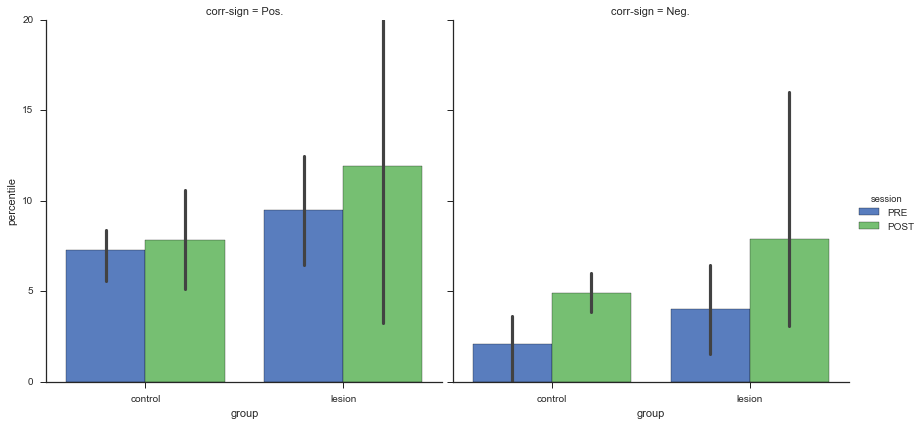

In [12]:
sns.factorplot(x="group", y="percentile", data=slpDB,size=6,hue='session', kind="bar", palette="muted",col='corr-sign')
#sns.factorplot(x="group", y="Neg.", data=prcndb,size=6, kind="violin", palette="muted")

In [16]:
slpDB = []
for animal in set(corrMax.animal):
    print animal
    df = corrMax[corrMax.animal==animal]
    Pdf = df[df.correlation>0.80]
    Pdf1 = Pdf[Pdf.session=='PRE']
    Pdf2 = Pdf[Pdf.session=='POST']
    Ndf = df[df.correlation<-0.8]
    Ndf1 = Ndf[Ndf.session=='PRE']
    Ndf2 = Ndf[Ndf.session=='POST']
    df1size = np.float(df[df.session=='PRE'].shape[0])
    df2size = np.float(df[df.session=='POST'].shape[0])
    P1size = Pdf1.shape[0]
    P2size = Pdf2.shape[0]
    N1size = Ndf1.shape[0]
    N2size = Ndf2.shape[0]
    print P1size,df1size,P2size,df2size
    if P1size:
        #print Pdf1.group[Pdf1.index[0]],Pdf1.animal[Pdf1.index[0]],Pdf1.session[Pdf1.index[0]]
        #print Ndf2.group[Ndf2.index[0]],Ndf2.animal[Ndf2.index[0]],Ndf2.session[Ndf2.index[0]]
        slpDB.append(np.transpose([1e2*P1size/df1size,'Pos.',Pdf1.group[Pdf1.index[0]],Pdf1.animal[Pdf1.index[0]],Pdf1.session[Pdf1.index[0]]]))
        slpDB.append(np.transpose([1e2*N1size/df1size,'Neg.',Pdf1.group[Pdf1.index[0]],Pdf1.animal[Pdf1.index[0]],Pdf1.session[Pdf1.index[0]]]))
    slpDB.append(np.transpose([1e2*P2size/df2size,'Pos.',Ndf2.group[Ndf2.index[0]],Ndf2.animal[Ndf2.index[0]],Ndf2.session[Ndf2.index[0]]]))
    slpDB.append(np.transpose([1e2*N2size/df2size,'Neg.',Ndf2.group[Ndf2.index[0]],Ndf2.animal[Ndf2.index[0]],Ndf2.session[Ndf2.index[0]]]))
slpDB = pd.DataFrame(slpDB,columns=['percentile','corr-sign','group','animal','session']).convert_objects(convert_numeric=True)

Rat3906
288 3438.0 311 3985.0
Rat434
48 385.0 17 522.0
Rat3661
79 998.0 119 1122.0
Rat3838
2 31.0 11 88.0
Rat3839
1 18.0 6 117.0
Rat3656
0 6.0 5 25.0


/home/chenani/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:25: FutureWarning: convert_objects is deprecated.  Use the data-type specific converters pd.to_datetime, pd.to_timedelta and pd.to_numeric.


In [14]:
Ndf

,animal,group,session,correlation
10721,Rat3656,lesion,POST,-0.830065
10722,Rat3656,lesion,POST,-0.917293
10724,Rat3656,lesion,POST,-0.879699
10726,Rat3656,lesion,POST,-0.849315


In [41]:
AllDB = prcndb.append(slpDB,ignore_index=True)

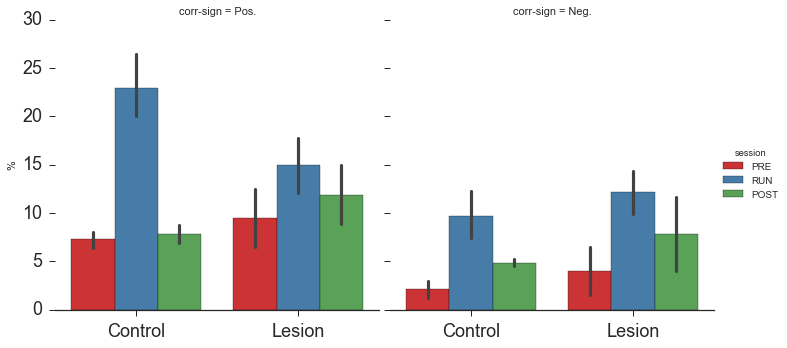

In [42]:
g= sns.factorplot(x="group", y="percentile", data=AllDB,size=5,hue_order=['PRE','RUN','POST'],sharey=True,ci=66,
                  order=['control','lesion'],hue='session',kind='bar', palette='Set1',col='corr-sign')
g.set_axis_labels("", "%")
g.set_yticklabels([0,5,10,15,20,25,30],fontsize=18)
g.set_xticklabels(["Control", "Lesion"],fontsize=18)
g.set_titles(fontsize=24)
g.despine(left=True)  
g.savefig('/home/chenani/ownCloud/Plots/SFN-poster/percentiles.eps')

Rat3906 0.837135763281 0.639615438397 0.459353317081
Rat434 0.837135763281 0.639615438397 0.459353317081
Rat3661 0.837135763281 0.639615438397 0.459353317081
Rat3838 0.837135763281 0.639615438397 0.459353317081
Rat3839 0.837135763281 0.639615438397 0.459353317081
Rat3656 0.837135763281 0.639615438397 0.459353317081


([array([ 0.05787037,  0.32407407,  0.56712963,  0.83333333,  0.59027778,
          0.69444444,  0.61342593,  0.47453704,  0.42824074,  0.3587963 ,
          0.2662037 ,  0.27777778,  0.3587963 ,  0.16203704,  0.17361111,
          0.16203704,  0.12731481,  0.21990741,  0.27777778,  0.18518519,
          0.18518519,  0.13888889,  0.12731481,  0.11574074,  0.13888889,
          0.10416667,  0.0462963 ,  0.18518519,  0.10416667,  0.12731481,
          0.0462963 ,  0.0462963 ,  0.13888889,  0.13888889,  0.06944444,
          0.15046296,  0.12731481,  0.11574074,  0.0462963 ,  0.0462963 ,
          0.12731481,  0.06944444,  0.05787037,  0.0462963 ,  0.0462963 ,
          0.06944444,  0.12731481,  0.06944444,  0.03472222]),
  array([ 0.24271845,  1.32281553,  1.0315534 ,  0.87378641,  0.63106796,
          0.61893204,  0.52184466,  0.35194175,  0.36407767,  0.25485437,
          0.20631068,  0.2184466 ,  0.14563107,  0.15776699,  0.2184466 ,
          0.13349515,  0.08495146,  0.19417476,  

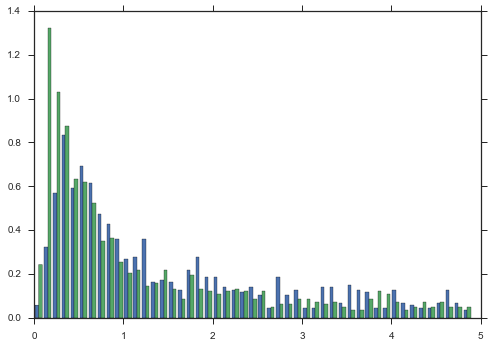

In [104]:
ratesDB = []
for animal in set(sleepDB.animal):
    df = sleepDB[sleepDB.animal=='Rat434']
    dfPr = df[df.session=='sleep01']
    dfPo = df[df.session=='sleep02']
    ieiPr = np.diff(dfPr['t_peak'])
    ieiPo = np.diff(dfPo['t_peak'])
    print animal,1e3/(ieiPr.mean()),1e3/ieiPr.std(),1e3/ieiPo.mean()
pl.hist([1e3/ieiPr,1e3/ieiPo],np.arange(0,5,0.1),normed=True);
#pd.DataFrame(slpDB,columns=['percentile','corr-sign','group','animal','session']).convert_objects(convert_numeric=True)

In [47]:
for animal in set(replayDB.animal):
    df = sleepDB[replayDB.animal==animal]
    dfPr = df[df.session=='sleep01']
    dfPo = df[df.session=='sleep02']
    ieiPr = np.diff(dfPr['t_peak'])
    ieiPo = np.diff(dfPo['t_peak'])
    print animal,1e3/ieiPr.mean(),1e3/ieiPo.mean()

/home/chenani/anaconda/lib/python2.7/site-packages/pandas/core/frame.py:1997: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  "DataFrame index.", UserWarning)


IndexingError: Unalignable boolean Series key provided

In [60]:
print set(AllDB[AllDB.group=='control'].animal)
print set(AllDB[AllDB.group=='lesion'].animal)
print set(slpDB[slpDB.group=='control'].animal)
print set(slpDB[slpDB.group=='lesion'].animal)

set(['Rat3906', 'Rat614', 'Rat3661', 'Rat616', 'Rat3839'])
set(['Rat434', 'Rat3837', 'Rat3656', 'Rat405', 'Rat3838'])
set(['Rat3906', 'Rat3661', 'Rat3839'])
set(['Rat434', 'Rat3656', 'Rat3838'])


In [66]:
Ndf

,animal,group,session,correlation
10710,Rat3656,lesion,POST,-0.790164
10721,Rat3656,lesion,POST,-0.830065
10722,Rat3656,lesion,POST,-0.917293
10723,Rat3656,lesion,POST,-0.780822
10724,Rat3656,lesion,POST,-0.879699
10726,Rat3656,lesion,POST,-0.849315
